## Importing neessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
#Train test split
from sklearn.model_selection import train_test_split
#Text pre-processing
import tensorflow as tf
from keras_tuner import RandomSearch
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

## Reading the file

In [2]:
df = pd.read_excel('rnn_lstm.xlsx')
df.head()

,id,likesCount,ownerProfilePicUrl,ownerUsername,postUrl,Unnamed: 5,text,Unnamed: 7,timestamp
0,17988118445479198,0,https://scontent-iad3-2.cdninstagram.com/v/t51...,frank21327,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I was afraid to start but when I did I was so ...,Scam,2023-08-01T00:02:06.000Z
1,17995515296305509,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,lawrence____larry.10,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I’m paying 5 grands to the first 7 people to m...,Scam,2023-08-01T00:02:44.000Z
2,17975784647410597,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,mari_o9754,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,@madison_exchange_1 I was referred to this pla...,Scam,2023-08-01T00:03:38.000Z
3,18375946198053653,0,https://scontent-iad3-2.cdninstagram.com/v/t51...,howard____thopson,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,PAYING 5 GRAND TO The First 5 People To Messag...,Scam,2023-08-01T00:04:17.000Z
4,17965259663603317,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,elly_x_elias,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I never believe I could get my partner back. I...,Scam,2023-08-01T00:04:57.000Z


In [3]:
columns = df.columns
columns

Index(['id', 'likesCount', 'ownerProfilePicUrl', 'ownerUsername', 'postUrl',
       'Unnamed: 5', 'text', 'Unnamed: 7', 'timestamp'],
      dtype='object')

In [4]:
# renaming the unnamed 7 column as the label column

df.rename(columns={'Unnamed: 7':'label'}, inplace=True)
df.head()

,id,likesCount,ownerProfilePicUrl,ownerUsername,postUrl,Unnamed: 5,text,label,timestamp
0,17988118445479198,0,https://scontent-iad3-2.cdninstagram.com/v/t51...,frank21327,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I was afraid to start but when I did I was so ...,Scam,2023-08-01T00:02:06.000Z
1,17995515296305509,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,lawrence____larry.10,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I’m paying 5 grands to the first 7 people to m...,Scam,2023-08-01T00:02:44.000Z
2,17975784647410597,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,mari_o9754,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,@madison_exchange_1 I was referred to this pla...,Scam,2023-08-01T00:03:38.000Z
3,18375946198053653,0,https://scontent-iad3-2.cdninstagram.com/v/t51...,howard____thopson,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,PAYING 5 GRAND TO The First 5 People To Messag...,Scam,2023-08-01T00:04:17.000Z
4,17965259663603317,0,https://scontent-iad3-1.cdninstagram.com/v/t51...,elly_x_elias,https://www.instagram.com/p/CvYY_VxNxNr/,NaN,I never believe I could get my partner back. I...,Scam,2023-08-01T00:04:57.000Z


## Extracting the texts and the labels needed for the model

In [5]:
df_req = df[['text', 'label']]
df_req

,text,label
0,I was afraid to start but when I did I was so ...,Scam
1,I’m paying 5 grands to the first 7 people to m...,Scam
2,@madison_exchange_1 I was referred to this pla...,Scam
3,PAYING 5 GRAND TO The First 5 People To Messag...,Scam
4,I never believe I could get my partner back. I...,Scam
...,...,...
2194,"I saw this, it was good",NaN
2195,@dancindome same,NaN
2196,@gailjjones Me neither. What’s going on. Did t...,NaN
2197,This mom is a horrible person.,NaN


In [6]:
df_req.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1964 non-null   object
 1   label   274 non-null    object
dtypes: object(2)
memory usage: 34.5+ KB


## Labeling the unlabelled labels

In [7]:
df_req['label'] = df_req['label'].apply(lambda x: 'Scam' if x == 'Scam' else 'Not Scam')
df_req

C:\Users\oyeni\AppData\Local\Temp\ipykernel_3608\2811111749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_req['label'] = df_req['label'].apply(lambda x: 'Scam' if x == 'Scam' else 'Not Scam')


,text,label
0,I was afraid to start but when I did I was so ...,Scam
1,I’m paying 5 grands to the first 7 people to m...,Scam
2,@madison_exchange_1 I was referred to this pla...,Scam
3,PAYING 5 GRAND TO The First 5 People To Messag...,Scam
4,I never believe I could get my partner back. I...,Scam
...,...,...
2194,"I saw this, it was good",Not Scam
2195,@dancindome same,Not Scam
2196,@gailjjones Me neither. What’s going on. Did t...,Not Scam
2197,This mom is a horrible person.,Not Scam


## Checking for the most/ frequently occuring word in one of the scam text and not scam text

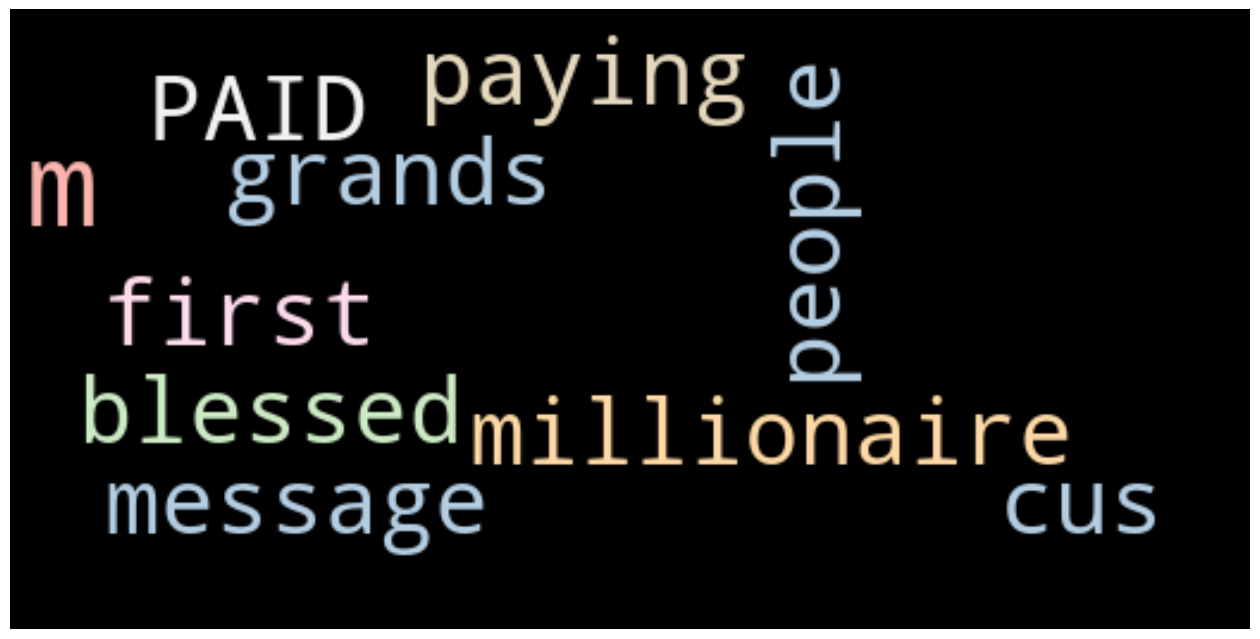

In [8]:
message_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS,
                           max_font_size = 50, background_color = "black",
                             colormap = 'Pastel1').generate(df_req['text'][1])
plt.figure(figsize=(16,10))
plt.imshow(message_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

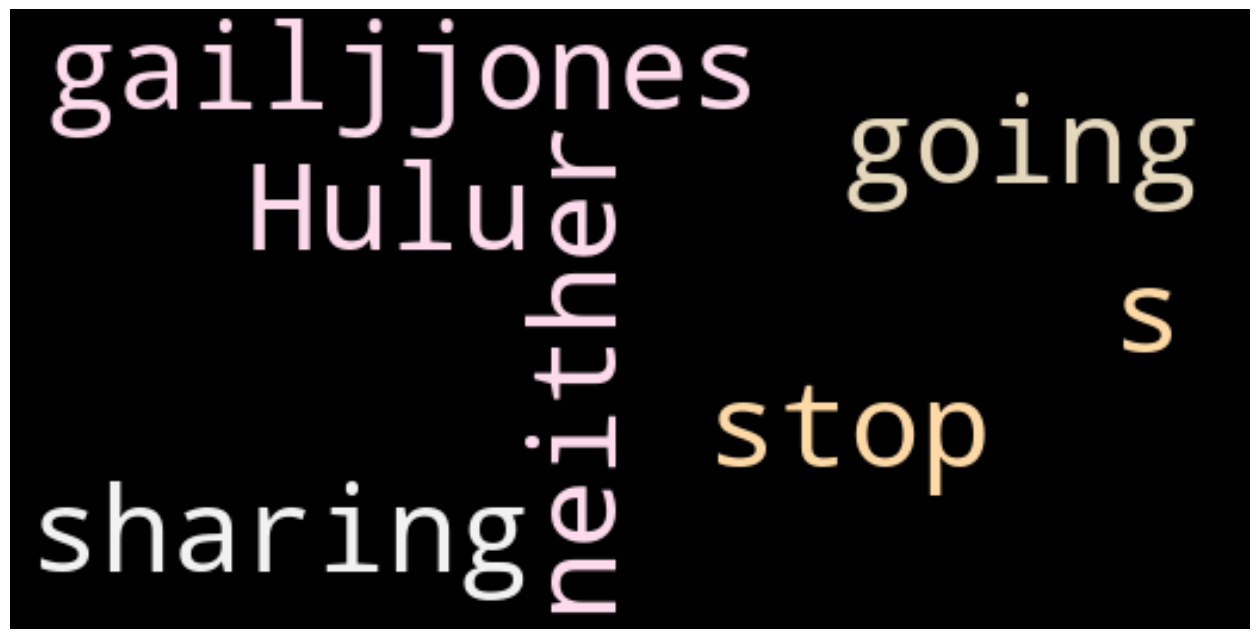

In [9]:
message_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS,
                           max_font_size = 50, background_color = "black",
                             colormap = 'Pastel1').generate(df_req['text'][2196])
plt.figure(figsize=(16,10))
plt.imshow(message_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

## Checking the balance of the data

<Figure size 600x800 with 0 Axes>

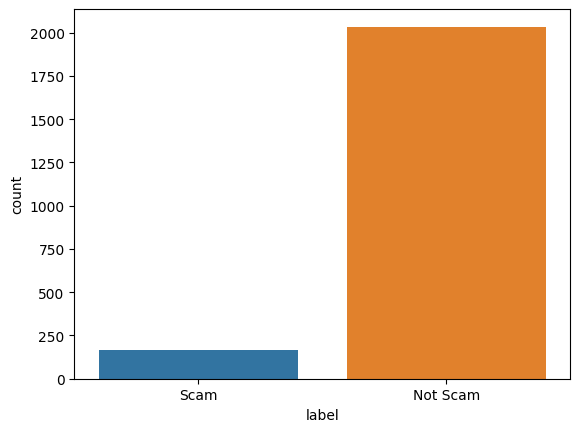

<Figure size 600x800 with 0 Axes>

In [10]:
df_req['label'].value_counts().to_dict()
sns.countplot(data=df_req, x='label')
plt.figure(figsize=(6,8))

#### From the graph above the data is not balanced..
#### There are more not scam than scam

### Using undersampling to balance the data

#### Undersampling is to under-sample the majority class randomly and uniformly. 
#### This can potentially lead to the loss of information. But if the examples of the majority class are near to others, this method might yield good results.

## Text Preprocessing

In [11]:
# checking the counts
df_req['text'].apply(lambda x: type(x)).value_counts()

<class 'str'>      1964
<class 'float'>     235
Name: text, dtype: int64

In [12]:
def remove_floating_points(df):
    df['type'] = df['text'].apply(lambda x: type(x))
    df['type'] = df['type'].apply(lambda x:'str' if str(x).__contains__('str') else 'float')
    df = df[df['type'] != 'float']
    df = df.reset_index(drop=True)
    return df

In [13]:
df_req = remove_floating_points(df_req)

C:\Users\oyeni\AppData\Local\Temp\ipykernel_3608\3293074998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['text'].apply(lambda x: type(x))
C:\Users\oyeni\AppData\Local\Temp\ipykernel_3608\3293074998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].apply(lambda x:'str' if str(x).__contains__('str') else 'float')


#### This function takes the input text, finds all floating-point numbers using the regular expression pattern, and replaces each of them with their string representation using the `replace` method. After preprocessing, the text will no longer contain floating-point numbers, making it easier for further text processing.

In [14]:
import re

def convert_floats_to_strings(text):
    # Define the regular expression pattern for floating-point numbers
    pattern = r"\d+\.\d+"

    # Find all occurrences of floating-point numbers in the text
    floats = re.findall(pattern, text)

    # Replace each floating-point number with its string representation
    for f in floats:
        text = text.replace(f, str(f))

    return text

In [15]:
df_req['text'] = df_req['text'].apply(lambda x: convert_floats_to_strings(x))

In [16]:
# Get length column for each text
df_req['text_length'] = df_req['text'].apply(lambda x: len(x))
df_req['value'] = df_req['label'].map({'Scam':0, 'Not Scam':1})
text_val = df_req['value'].values
df_req.head()

,text,label,type,text_length,value
0,I was afraid to start but when I did I was so ...,Scam,str,127,0
1,I’m paying 5 grands to the first 7 people to m...,Scam,str,101,0
2,@madison_exchange_1 I was referred to this pla...,Scam,str,220,0
3,PAYING 5 GRAND TO The First 5 People To Messag...,Scam,str,132,0
4,I never believe I could get my partner back. I...,Scam,str,424,0


In [17]:
## Train Test Split
x_train, x_test, y_train, y_test = train_test_split(df_req['text'], text_val, test_size=0.2, random_state=434)

#### Tokenization

#### The Tokenizer will perform all the necessary pre-processing steps:

    - tokenize into word character (word level)
    - num_words for maximum number of unique tokens
    - filter out the punctuation terms
    - convert all words to lower case
    - convert all words to integer index

In [18]:
# Defining pre-processing parameters
max_len = 50 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

#### This code will convert the input text to lowercase, tokenize it into individual words, remove punctuation and common stopwords from English, and then join the remaining tokens back into a preprocessed text.

In [19]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

def preprocess_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text.lower())

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join the tokens back into a preprocessed text
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [20]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [21]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

5088

#### Sequence and Padding
####    
    - padding : ‘pre’ or ‘post (default pre). By using pre, we’ll pad before each sequence and post will pad after each sequence.
    - maxlen : maximum length of all sequences. If not provided, by default it will use the maximum length of the longest sentence.
    - truncating : ‘pre’ or ‘post’ (default ‘pre’). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. ‘pre’ option will truncate at the beginning where as ‘post’ will  truncate at the end of the sequences.

#### Training data

In [22]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

#### Testing data

In [23]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [24]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1571, 50)
Shape of testing tensor:  (393, 50)


## Training the model

In [25]:
# Define parameter
vocab_size = 500 
embedding_dim = 16
drop_value = 0.2
n_dense = 24

# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

    Sequential calls for Keras sequential model in which layer added in a sequence. The embedding layer maps each word to a N-dimensional vector of real numbers. The embedding_dim is the size of the word_vector , in this case we use 16. Because the embedding layer is the first hidden layer in our model, we need to set our input layer as defined by the input_length = max_len

    The GlobalAveragePooling1D as the pooling layer, which helps to reduce the number of parameters in the model and to avoid overfitting.

    The dense layer with activation function relu followed by a dropout layer to avoid overfitting and a final output layer with sigmoid activation function. The sigmoid activation function outputs probabilities will between 0 and 1.

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [27]:
# compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

    We use thebinary_crossentropy as a loss function because the output of the model is binary and for the optimizer.

### Train the model

In [28]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
50/50 - 2s - loss: 0.6238 - accuracy: 0.8797 - val_loss: 0.5335 - val_accuracy: 0.9135 - 2s/epoch - 36ms/step
Epoch 2/30
50/50 - 0s - loss: 0.4345 - accuracy: 0.9166 - val_loss: 0.3369 - val_accuracy: 0.9135 - 108ms/epoch - 2ms/step
Epoch 3/30
50/50 - 0s - loss: 0.2912 - accuracy: 0.9166 - val_loss: 0.2660 - val_accuracy: 0.9135 - 106ms/epoch - 2ms/step
Epoch 4/30
50/50 - 0s - loss: 0.2585 - accuracy: 0.9166 - val_loss: 0.2555 - val_accuracy: 0.9135 - 111ms/epoch - 2ms/step
Epoch 5/30
50/50 - 0s - loss: 0.2531 - accuracy: 0.9166 - val_loss: 0.2502 - val_accuracy: 0.9135 - 108ms/epoch - 2ms/step
Epoch 6/30
50/50 - 0s - loss: 0.2399 - accuracy: 0.9166 - val_loss: 0.2458 - val_accuracy: 0.9135 - 107ms/epoch - 2ms/step
Epoch 7/30
50/50 - 0s - loss: 0.2330 - accuracy: 0.9166 - val_loss: 0.2407 - val_accuracy: 0.9135 - 108ms/epoch - 2ms/step
Epoch 8/30
50/50 - 0s - loss: 0.2269 - accuracy: 0.9173 - val_loss: 0.2359 - val_accuracy: 0.9135 - 125ms/epoch - 2ms/step
Epoch 9/30
50/50 -

     epoch : number of times the learning algorithm will work through the entire training data.
     callbacks : to pass the early stopping parameter. EarlyStopping(monitor=’val_loss’, patience=2) was used to define that we want to monitor the validation loss and if the validation loss is not improved after 2 epochs, then the model training will stop. This technique helps to avoid overfitting problem.
     verbose : 2 , it will show us loss and accuracy on each epoch.

In [29]:
model.evaluate(testing_padded, y_test)

13/13 [==============================] - 0s 1ms/step - loss: 0.1969 - accuracy: 0.9135


[0.19688408076763153, 0.9134860038757324]

    Checking the loss and accuracy on training and testing data

In [30]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

7/7 - 0s - loss: 0.1061 - accuracy: 0.9637 - 52ms/epoch - 7ms/step
2/2 - 0s - loss: 0.1969 - accuracy: 0.9135 - 25ms/epoch - 13ms/step
Train accuracy: 96.37
Valid accuracy: 91.35


13/13 [==============================] - 0s 1ms/step


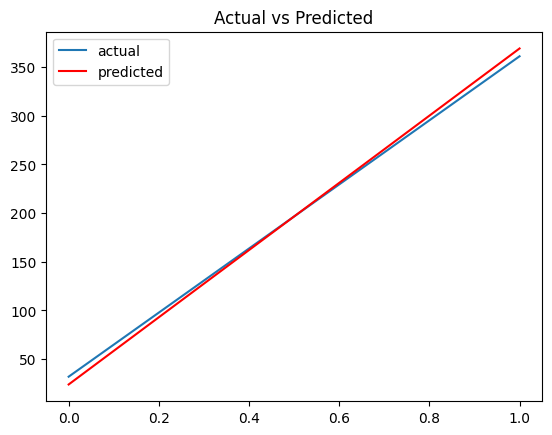

In [31]:
import math
pred = model.predict(testing_padded)
pred = pd.DataFrame(pred, columns=['predicted'])
pred['predicted'] = pred['predicted'].apply(lambda x: np.round(x))
pred['actual'] = pd.DataFrame(y_train)
pred

pred['actual'].value_counts().plot(label='actual')
pred['predicted'].value_counts().plot(label='predicted', color='red')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig('lstm.jpg')

    An accuracy of approx 96% on train set 
    and 91% on test set
    The graph above is a visual representative of the accuracy of the model.
    The line overlaps showing that the model performs well on the data.


### LSTM
#### Long Short Term Memory

#### Building an LSTM model

In [32]:
# Define parameter
n_lstm = 128
drop_lstm = 0.2

# Define LSTM Model 
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

#### Compiling and Training the model

In [34]:
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [35]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
50/50 - 7s - loss: 0.3791 - accuracy: 0.8988 - val_loss: 0.2985 - val_accuracy: 0.9135 - 7s/epoch - 136ms/step
Epoch 2/30
50/50 - 2s - loss: 0.2878 - accuracy: 0.9166 - val_loss: 0.2922 - val_accuracy: 0.9135 - 2s/epoch - 50ms/step
Epoch 3/30
50/50 - 2s - loss: 0.2493 - accuracy: 0.9166 - val_loss: 0.2112 - val_accuracy: 0.9033 - 2s/epoch - 45ms/step
Epoch 4/30
50/50 - 2s - loss: 0.1698 - accuracy: 0.9402 - val_loss: 0.3523 - val_accuracy: 0.8295 - 2s/epoch - 39ms/step
Epoch 5/30
50/50 - 2s - loss: 0.1391 - accuracy: 0.9535 - val_loss: 0.1912 - val_accuracy: 0.9160 - 2s/epoch - 39ms/step
Epoch 6/30
50/50 - 2s - loss: 0.1167 - accuracy: 0.9644 - val_loss: 0.1730 - val_accuracy: 0.9262 - 2s/epoch - 45ms/step
Epoch 7/30
50/50 - 2s - loss: 0.1612 - accuracy: 0.9478 - val_loss: 0.2075 - val_accuracy: 0.9262 - 2s/epoch - 48ms/step
Epoch 8/30
50/50 - 3s - loss: 0.1093 - accuracy: 0.9631 - val_loss: 0.1811 - val_accuracy: 0.9288 - 3s/epoch - 53ms/step


In [36]:
train_dense_results = model1.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model1.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

7/7 - 1s - loss: 0.0951 - accuracy: 0.9701 - 518ms/epoch - 74ms/step
2/2 - 0s - loss: 0.1811 - accuracy: 0.9288 - 146ms/epoch - 73ms/step
Train accuracy: 97.01
Valid accuracy: 92.88


13/13 [==============================] - 1s 14ms/step


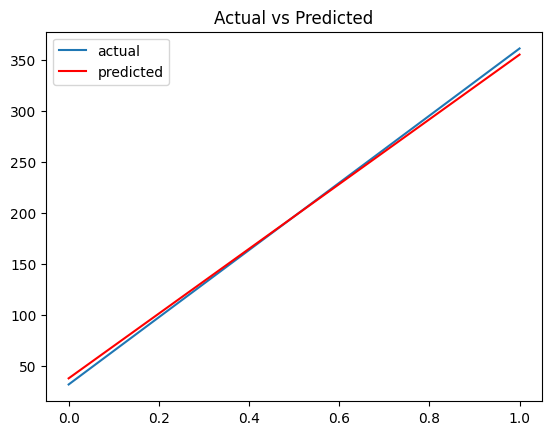

In [37]:
import math
pred = model1.predict(testing_padded)
pred = pd.DataFrame(pred, columns=['predicted'])
pred['predicted'] = pred['predicted'].apply(lambda x: np.round(x))
pred['actual'] = pd.DataFrame(y_train)
pred

pred['actual'].value_counts().plot(label='actual')
pred['predicted'].value_counts().plot(label='predicted', color='red')
plt.title('Actual vs Predicted')
plt.legend()

    An accuracy of 91% on train set
    and 91% on test set
    The graph above is a visual representative of the accuracy of the LSTM model
    The line overlaps showing that the model performs a bit lesser than the initially used model.

### GATED RECURRENT UNIT

    A Gated Recurrent Unit, or GRU, is a type of recurrent neural network that is similar to an LSTM, but only has two gates 
        - a reset gate
        - an update gate 
    and notably lacks an output gate. Fewer parameters means GRUs are generally easier/faster to train than their LSTM counterparts.

#### Defining the model

In [38]:
model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(SpatialDropout1D(0.2))
model2.add(GRU(128, return_sequences = False))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation = 'sigmoid'))

#### compiling the model

In [39]:
model2.compile(loss = 'binary_crossentropy',
                       optimizer = 'adam',
                       metrics=['accuracy'])

#### Training the model

In [40]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
50/50 - 6s - loss: 0.3820 - accuracy: 0.9013 - val_loss: 0.2958 - val_accuracy: 0.9135 - 6s/epoch - 117ms/step
Epoch 2/30
50/50 - 2s - loss: 0.2799 - accuracy: 0.9166 - val_loss: 0.2920 - val_accuracy: 0.9135 - 2s/epoch - 36ms/step
Epoch 3/30
50/50 - 2s - loss: 0.2765 - accuracy: 0.9166 - val_loss: 0.2906 - val_accuracy: 0.9135 - 2s/epoch - 38ms/step
Epoch 4/30
50/50 - 2s - loss: 0.2730 - accuracy: 0.9166 - val_loss: 0.2857 - val_accuracy: 0.9135 - 2s/epoch - 46ms/step
Epoch 5/30
50/50 - 2s - loss: 0.2627 - accuracy: 0.9179 - val_loss: 0.2699 - val_accuracy: 0.9160 - 2s/epoch - 43ms/step
Epoch 6/30
50/50 - 2s - loss: 0.2126 - accuracy: 0.9268 - val_loss: 0.2218 - val_accuracy: 0.8982 - 2s/epoch - 45ms/step
Epoch 7/30
50/50 - 2s - loss: 0.1678 - accuracy: 0.9287 - val_loss: 0.1999 - val_accuracy: 0.9008 - 2s/epoch - 43ms/step
Epoch 8/30
50/50 - 2s - loss: 0.1546 - accuracy: 0.9363 - val_loss: 0.1849 - val_accuracy: 0.9008 - 2s/epoch - 42ms/step
Epoch 9/30
50/50 - 2s - loss: 0

In [41]:
train_dense_results = model2.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model2.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

7/7 - 0s - loss: 0.1127 - accuracy: 0.9497 - 299ms/epoch - 43ms/step
2/2 - 0s - loss: 0.1942 - accuracy: 0.9008 - 129ms/epoch - 64ms/step
Train accuracy: 94.97
Valid accuracy: 90.08


13/13 [==============================] - 1s 10ms/step


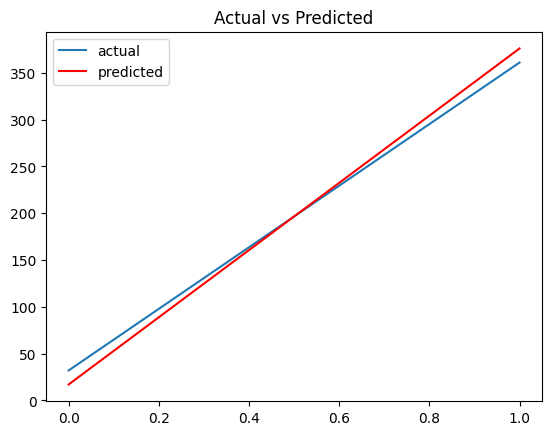

In [42]:
import math
pred = model2.predict(testing_padded)
pred = pd.DataFrame(pred, columns=['predicted'])
pred['predicted'] = pred['predicted'].apply(lambda x: np.round(x))
pred['actual'] = pd.DataFrame(y_train)
pred

pred['actual'].value_counts().plot(label='actual')
pred['predicted'].value_counts().plot(label='predicted', color='red')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig('improved.jpg')

    Accuracy of 96% on train set 
    and 93% on test set
    The graph above is a visual representative of the accuracy of the GRU model
    The line overlaps showing that the model performs better than the initially used LSTM model.

### TUNING THE HYPERPARAMETERS USING KERAS TUNER 
    to further improve the LSTM model that was initially built

In [43]:
def build_model(hp):
    #hp means hyper parameters
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(drop_lstm))
    model.add(LSTM(n_lstm, return_sequences=False))
    model.add(Dropout(drop_lstm)) 
    #providing range for number of neurons in a hidden layer
    model.add(Dense(units=hp.Int('num_of_neurons',min_value=32,max_value=512,step=32),
                                    activation='sigmoid'))
    #output layer
    model.add(Dense(1,activation='softmax'))
    #compiling the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [44]:
tuner=RandomSearch(build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner',
    project_name='spam_detector')

INFO:tensorflow:Reloading Tuner from tuner\spam_detector\tuner0.json


In [45]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_of_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [46]:
tuner.search(training_padded, y_train,epochs=10,validation_data=(testing_padded ,y_test))

INFO:tensorflow:Oracle triggered exit


13/13 [==============================] - 0s 14ms/step


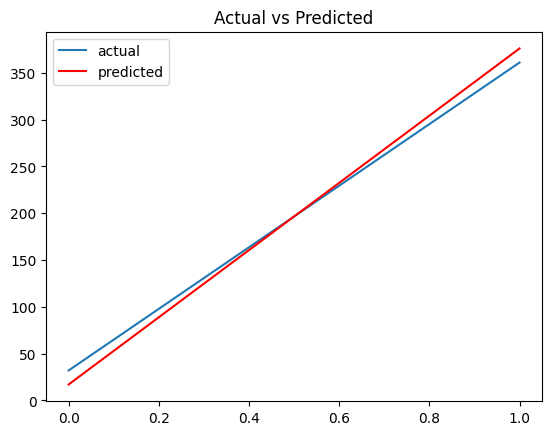

In [47]:
import math
pred = model2.predict(testing_padded)
pred = pd.DataFrame(pred, columns=['predicted'])
pred['predicted'] = pred['predicted'].apply(lambda x: np.round(x))
pred['actual'] = pd.DataFrame(y_train)
pred

pred['actual'].value_counts().plot(label='actual')
pred['predicted'].value_counts().plot(label='predicted', color='red')
plt.title('Actual vs Predicted')
plt.legend()